# New York Movies Scene


In [54]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [2]:
df = pd.read_csv('Film_Permits.csv',skipinitialspace = True)
df = pd.DataFrame(df)
df.dropna(inplace=True)

In [3]:
# set date time format
df["StartDateTime"] = pd.to_datetime(df["StartDateTime"])
df["EndDateTime"] = pd.to_datetime(df["EndDateTime"])
df["EnteredOn"] = pd.to_datetime(df["EnteredOn"])

In [4]:
#clean CommunityBoard and PolicePrecinct
def setMean(columns):
    mean = []
    for cell in df[columns]:
    #     cell to string
        getCell = str(cell)
        #   if the first character is not a number remove it
        if getCell[0].isnumeric() == False:
            getCell = getCell[1:]
    #     cell to numpy array seperated by comma
        seperateCell = np.array(np.fromstring(getCell, dtype=int, sep=','))
    #     appaned mean
        mean.append(int(np.mean(seperateCell)))
    return mean

# clean Zipcodes
def setZip(code):
    postCode = []
    for zipcode in df['ZipCode(s)']:
        getZip = str(zipcode)
        # check if , is in the string
        if "," in getZip:
            # slicing off after length computation
            res = getZip[:getZip.index(',') + len(',') -1]
            postCode.append(int(res))
        else:
            postCode.append(int(getZip))
    return postCode

In [5]:
movie_scene = df
# remove spaces
movie_scene['CommunityBoard(s)'] = movie_scene['CommunityBoard(s)'].str.replace(' ','')
movie_scene['PolicePrecinct(s)'] = movie_scene['PolicePrecinct(s)'].str.replace(' ','')
# convert muitple CommunityBoard & PolicePrecinct to mean and set coloumn values as mean
movie_scene['CommunityBoard(s)'] =  setMean('CommunityBoard(s)')
movie_scene['PolicePrecinct(s)'] = setMean('PolicePrecinct(s)')
# convert multiple zipcodes to one zip code and replace zip code coloumn
movie_scene['ZipCode(s)'] = setZip('ZipCode(s)')
movie_scene.head()

,EventID,EventType,StartDateTime,EndDateTime,EnteredOn,EventAgency,ParkingHeld,Borough,CommunityBoard(s),PolicePrecinct(s),Category,SubCategoryName,Country,ZipCode(s)
0,446040,Shooting Permit,2018-10-19 14:00:00,2018-10-20 04:00:00,2018-10-16 11:57:27,"Mayor's Office of Film, Theatre & Broadcasting",THOMPSON STREET between PRINCE STREET and SPRI...,Manhattan,2,1,Television,Cable-episodic,United States of America,10012
1,446168,Shooting Permit,2018-10-19 14:00:00,2018-10-20 02:00:00,2018-10-16 19:03:56,"Mayor's Office of Film, Theatre & Broadcasting",MARBLE HILL AVENUE between WEST 227 STREET an...,Manhattan,10,42,Film,Feature,United States of America,10034
2,186438,Shooting Permit,2014-10-30 07:00:00,2014-10-31 02:00:00,2014-10-27 12:14:15,"Mayor's Office of Film, Theatre & Broadcasting",LAUREL HILL BLVD between REVIEW AVENUE and RUS...,Queens,3,106,Television,Episodic series,United States of America,11378
3,445255,Shooting Permit,2018-10-20 07:00:00,2018-10-20 18:00:00,2018-10-09 21:34:58,"Mayor's Office of Film, Theatre & Broadcasting",JORALEMON STREET between BOERUM PLACE and COUR...,Brooklyn,2,84,Still Photography,Not Applicable,United States of America,11201
4,128794,Theater Load in and Load Outs,2013-11-16 00:01:00,2013-11-17 06:00:00,2013-11-07 15:48:28,"Mayor's Office of Film, Theatre & Broadcasting",WEST 31 STREET between 7 AVENUE and 8 AVENUE...,Manhattan,4,14,Theater,Theater,United States of America,10001


In [6]:
# group by StartDateTime
month = pd.DataFrame(movie_scene.groupby(pd.to_datetime(movie_scene['StartDateTime'])))
# get month name 
month = pd.DataFrame(month.groupby(month[0].dt.month_name()))
# get months only
month = pd.DataFrame(month[0])

In [7]:
# pre covid numbers
# covid start date in the usa 
start_date = pd.to_datetime('1/1/2020')
# get movies where Category == Film
monthlyFilm = movie_scene.where(movie_scene['Category'] == 'Film').dropna()
# set date constraints
monthlyFilm.loc[(monthlyFilm['StartDateTime'] < start_date)]
# cound by month name
monthlyFilm = pd.DataFrame(monthlyFilm.groupby(pd.to_datetime(monthlyFilm['StartDateTime']).dt.month_name())['Category'].count())
monthlyFilm

,Category
StartDateTime,
April,881
August,1177
December,740
February,584
January,360
July,1287
June,1303
March,724
May,1075


In [8]:
# get covid numbers 
# set dates 
start_date = pd.to_datetime('1/1/2020')
end_date = pd.Timestamp.today()
# get only films
monthlyCovidFilm = movie_scene.where(movie_scene['Category'] == 'Film').dropna()
# set date constraints
monthlyCovidFilm = monthlyCovidFilm.loc[(monthlyCovidFilm['StartDateTime'] > start_date) & (monthlyCovidFilm['StartDateTime'] <= end_date)]
# 
monthlyCovidFilm = pd.DataFrame(monthlyCovidFilm.groupby(pd.to_datetime(monthlyCovidFilm['StartDateTime']).dt.month_name())['Category'].count())
monthlyCovidFilm

,Category
StartDateTime,
April,20
August,142
December,42
February,50
January,19
July,59
June,32
March,44
May,44


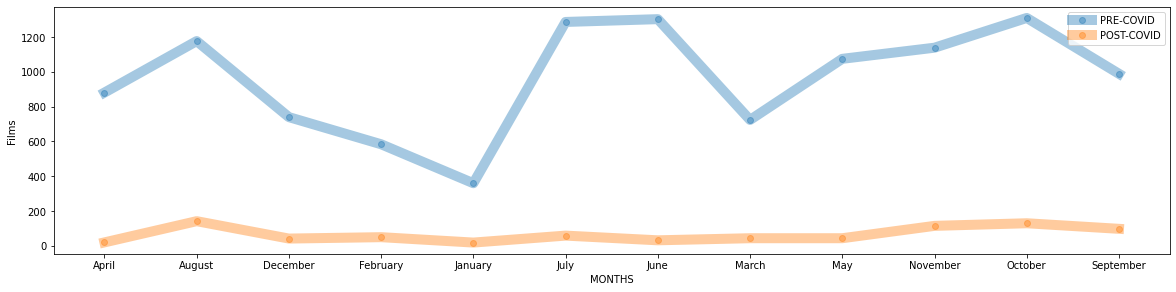

In [9]:
plt.rcParams['figure.figsize'] = (20,10)
plt.subplot(211)

preCovid = plt.plot_date(month[0], monthlyFilm, linestyle='solid', alpha=0.4, linewidth=10,label="PRE-COVID")
postCovid = plt.plot_date(month[0], monthlyCovidFilm, linestyle='solid', alpha=0.4, linewidth=10, label='POST-COVID')

leg = plt.legend(loc='upper right')
plt.xlabel('MONTHS')
plt.ylabel('Films')
plt.show()

In [91]:
overallDiration = movie_scene.groupby((movie_scene['EndDateTime'] - movie_scene['StartDateTime'])/ np.timedelta64(1, 'h')).count().reset_index()
# overallDiration.iloc[0]
overallDiration.rename(columns = {'index':'Duration'}, inplace = True)
overallDiration["Duration"] = overallDiration["Duration"].astype("float")
# remove films which took more than 50 days as they are outliers
overallDiration = pd.DataFrame(overallDiration.drop(np.where(overallDiration['Duration'] > 50)[0]))
overallDiration = overallDiration.dropna()

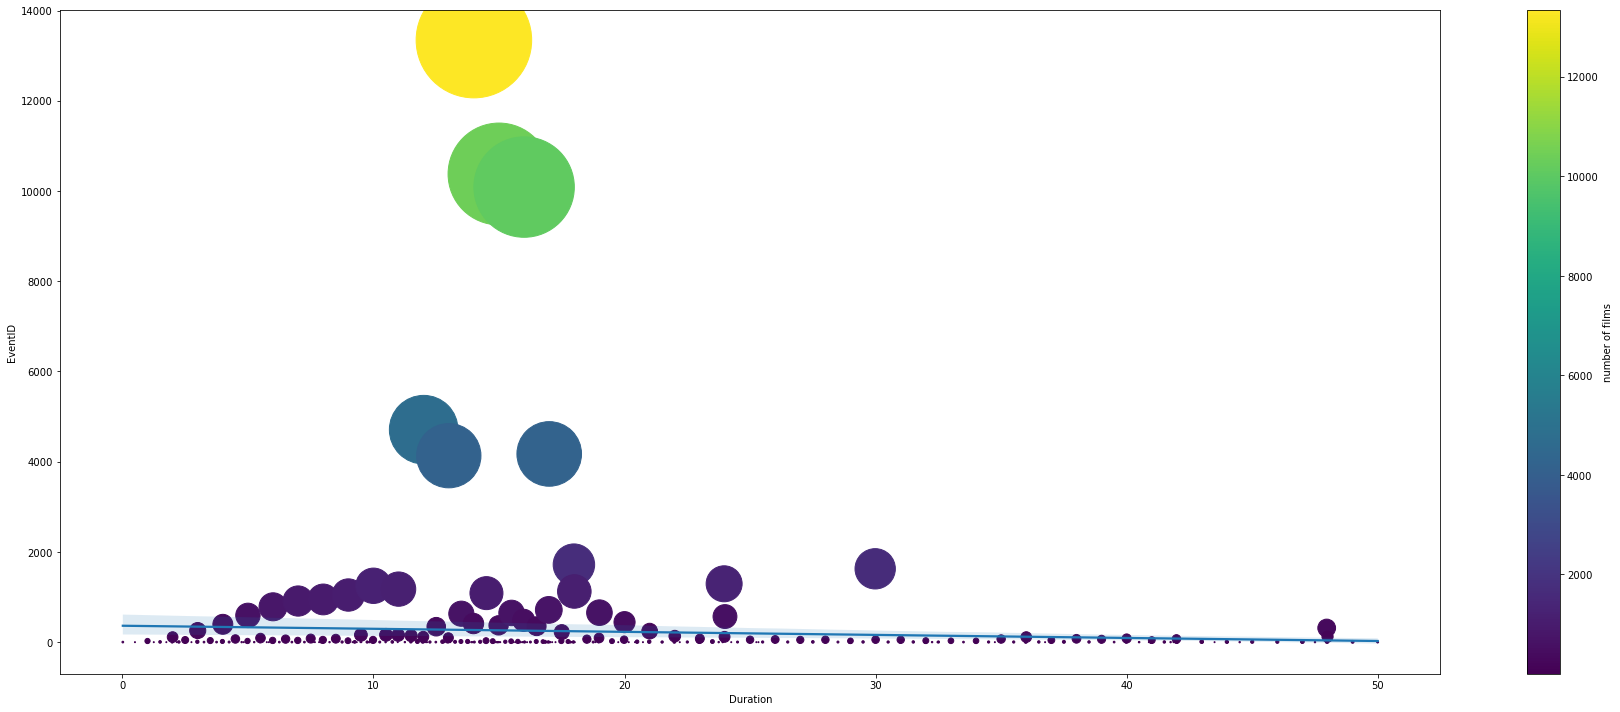

In [92]:
colors = np.random.rand(100)
plt.figure(figsize =(25, 10))
plt.scatter(x = overallDiration['Duration'], y = overallDiration['EventID'], c=overallDiration['EventID'], s=overallDiration['EventID'])
plt.xlabel('DURATION (DAYS)')
plt.ylabel('NUMBER OF FILMS')
cbar = plt.colorbar()
cbar.set_label('number of films')
# add regression line
sns.regplot(x="Duration", y="EventID", data=overallDiration, marker='')
plt.show()


In [12]:
def findList(name):
    return movie_scene[name].values.tolist()

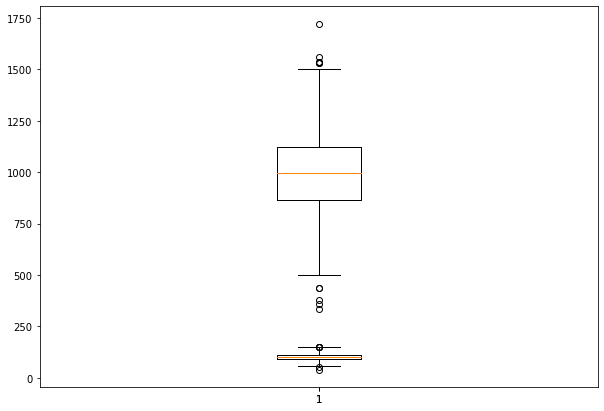

In [13]:
# Creating dataset
np.random.seed(10)
data = np.random.normal(100, 20, 200)
data2 = np.random.normal(1000, 200, 2000)
 
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(data)
plt.boxplot(data2)
 
# show plot
plt.show()

In [14]:
cc = movie_scene.groupby(movie_scene['Category']).count()
cc

,EventID,EventType,StartDateTime,EndDateTime,EnteredOn,EventAgency,ParkingHeld,Borough,CommunityBoard(s),PolicePrecinct(s),SubCategoryName,Country,ZipCode(s)
Category,,,,,,,,,,,,,
Commercial,5823,5823,5823,5823,5823,5823,5823,5823,5823,5823,5823,5823,5823
Documentary,337,337,337,337,337,337,337,337,337,337,337,337,337
Film,11569,11569,11569,11569,11569,11569,11569,11569,11569,11569,11569,11569,11569
Music Video,249,249,249,249,249,249,249,249,249,249,249,249,249
Red Carpet/Premiere,1,1,1,1,1,1,1,1,1,1,1,1,1
Still Photography,4319,4319,4319,4319,4319,4319,4319,4319,4319,4319,4319,4319,4319
Student,444,444,444,444,444,444,444,444,444,444,444,444,444
Television,41777,41777,41777,41777,41777,41777,41777,41777,41777,41777,41777,41777,41777
Theater,7160,7160,7160,7160,7160,7160,7160,7160,7160,7160,7160,7160,7160


In [15]:
# crimeDescription = movie_scene['Category'].unique()
# crimeDescription

In [16]:
# categoryDuration = pd.DataFrame()

# def duration(categoryName):
#     category = pd.DataFrame(movie_scene.where(movie_scene['Category'] == categoryName).dropna())
#     category = pd.DataFrame(category)
#     days
#     for cell in range(len(category)):
#         duration = category['EndDateTime'].iloc[cell] - category['StartDateTime'].iloc[cell]
#         days += duration
#     return days

# duration('Television')